![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# MACHINE LEARNING IN PRACTICE: END MODULE ASSIGNMENT 

The objective of this assignment is to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units by carrying out several tasks using the Anaconda/Scikit-Learn Python ML framework and its components.

# SECTION 2: EMISSIONS MODELLING AND INTERPRETATIONS

This section comprises the algorithms we have selected and the interpretations that arise from modelling these algorithms.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Step 2.1: Models choices and evaluations metrics considerations

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

import importlib
from helpers import utilities as utils

# Reload the module to reflect changes without restarting the kernel
importlib.reload(utils)

<module 'helpers.utilities' from '/Users/eyapene/Liverpool/ML in Practice/Jupyter/EMA/EmissionsML/helpers/utilities.py'>

In [4]:
X, y = utils.load_data('./preprocessed_data/final_dataset.csv', 
                       ['co2_avg', 'pm10_avg', 'pm25_avg', 'no2_avg']) 

In [5]:
X.head()

,vkm_motorcycle,vkm_taxi,vkm_petrol_car,vkm_diesel_car,vkm_electric_car,vkm_petrol_phv,vkm_diesel_phv,vkm_electric_phv,vkm_petrol_lgv,vkm_diesel_lgv,...,vkm_hgvs_rigid_3_axles,vkm_hgvs_rigid_4_or_more_axles,vkm_hgvs_articulated_3_to_4_axles,vkm_hgvs_articulated_5_axles,vkm_hgvs_articulated_6_axles,vkm_buses,vkm_coaches,laei_zone_Inner London,laei_zone_Non-GLA,laei_zone_Outer London
0,2289.0,307.0,111810.0,77272.0,662.0,1881.0,1547.0,26.0,195.0,22586.0,...,736.0,1451.0,531.0,2759.0,3659.0,0.0,327.0,0,1,0
1,2921.0,430.0,131006.0,90538.0,776.0,14550.0,11968.0,203.0,305.0,35317.0,...,344.0,687.0,258.0,1289.0,1718.0,0.0,1160.0,0,1,0
2,1568.0,180.0,68868.0,47595.0,408.0,808.0,665.0,11.0,224.0,25937.0,...,275.0,551.0,192.0,1042.0,1377.0,0.0,7746.0,0,1,0
3,429.0,82.0,20315.0,14040.0,120.0,522.0,429.0,7.0,45.0,5195.0,...,94.0,185.0,67.0,352.0,465.0,0.0,446.0,0,1,0
4,594.0,145.0,27918.0,19294.0,165.0,1299.0,1068.0,18.0,59.0,6848.0,...,137.0,265.0,96.0,506.0,666.0,1759.0,217.0,0,1,0


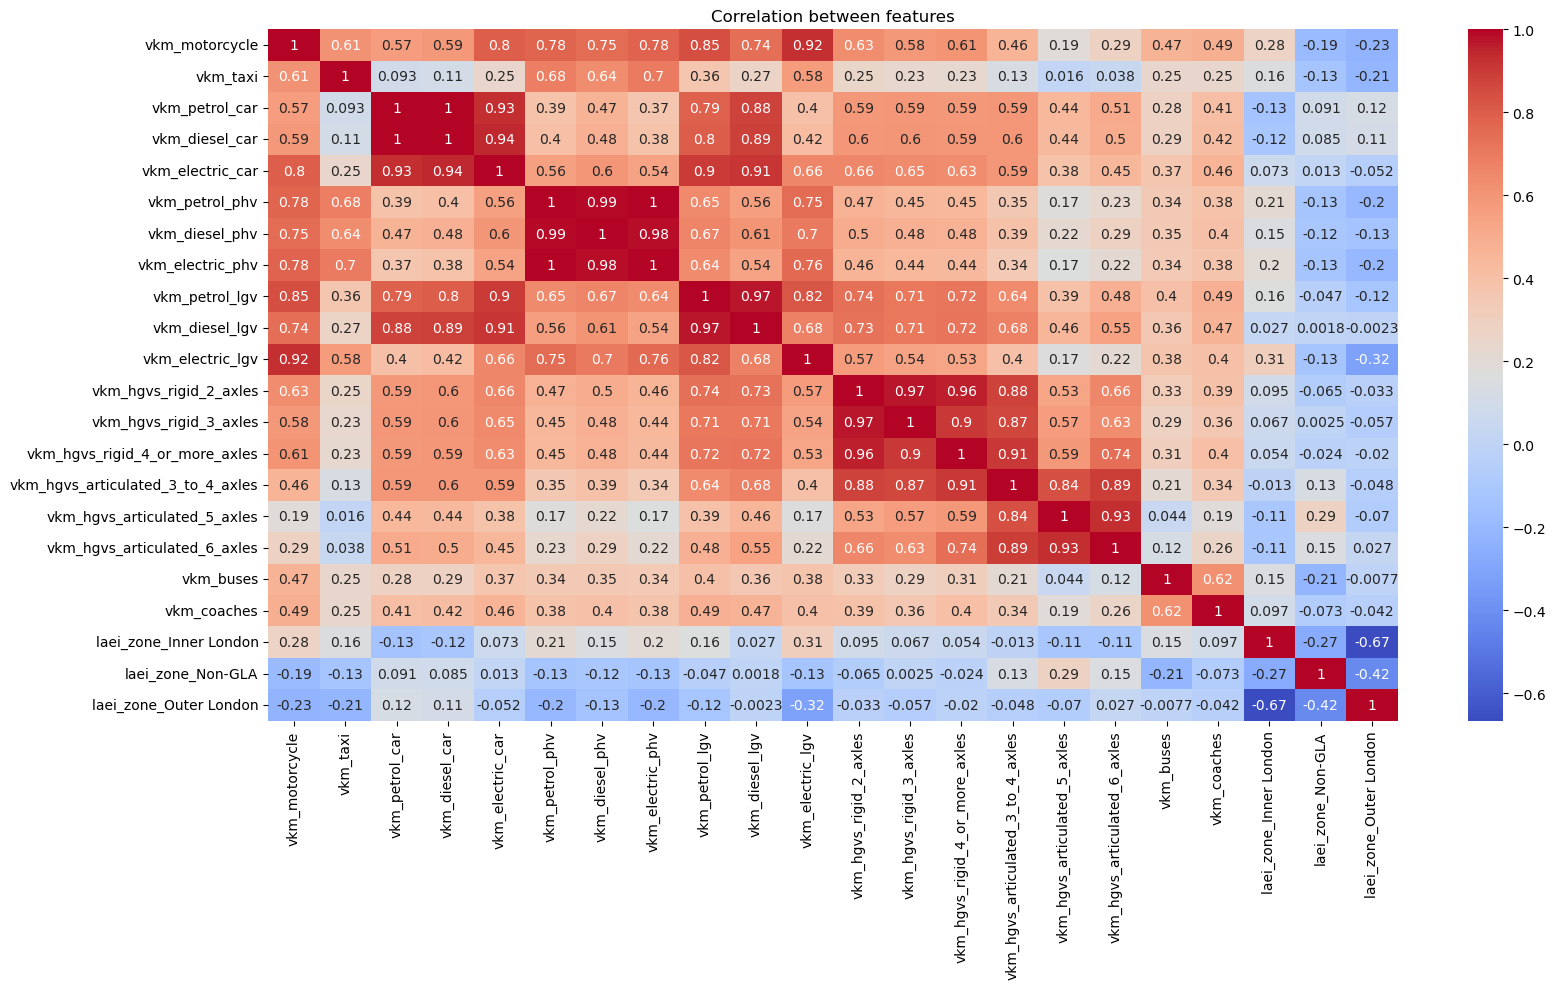

In [6]:
# Correlation overview of the features selected
utils.plot_correlation_heatmap(X)

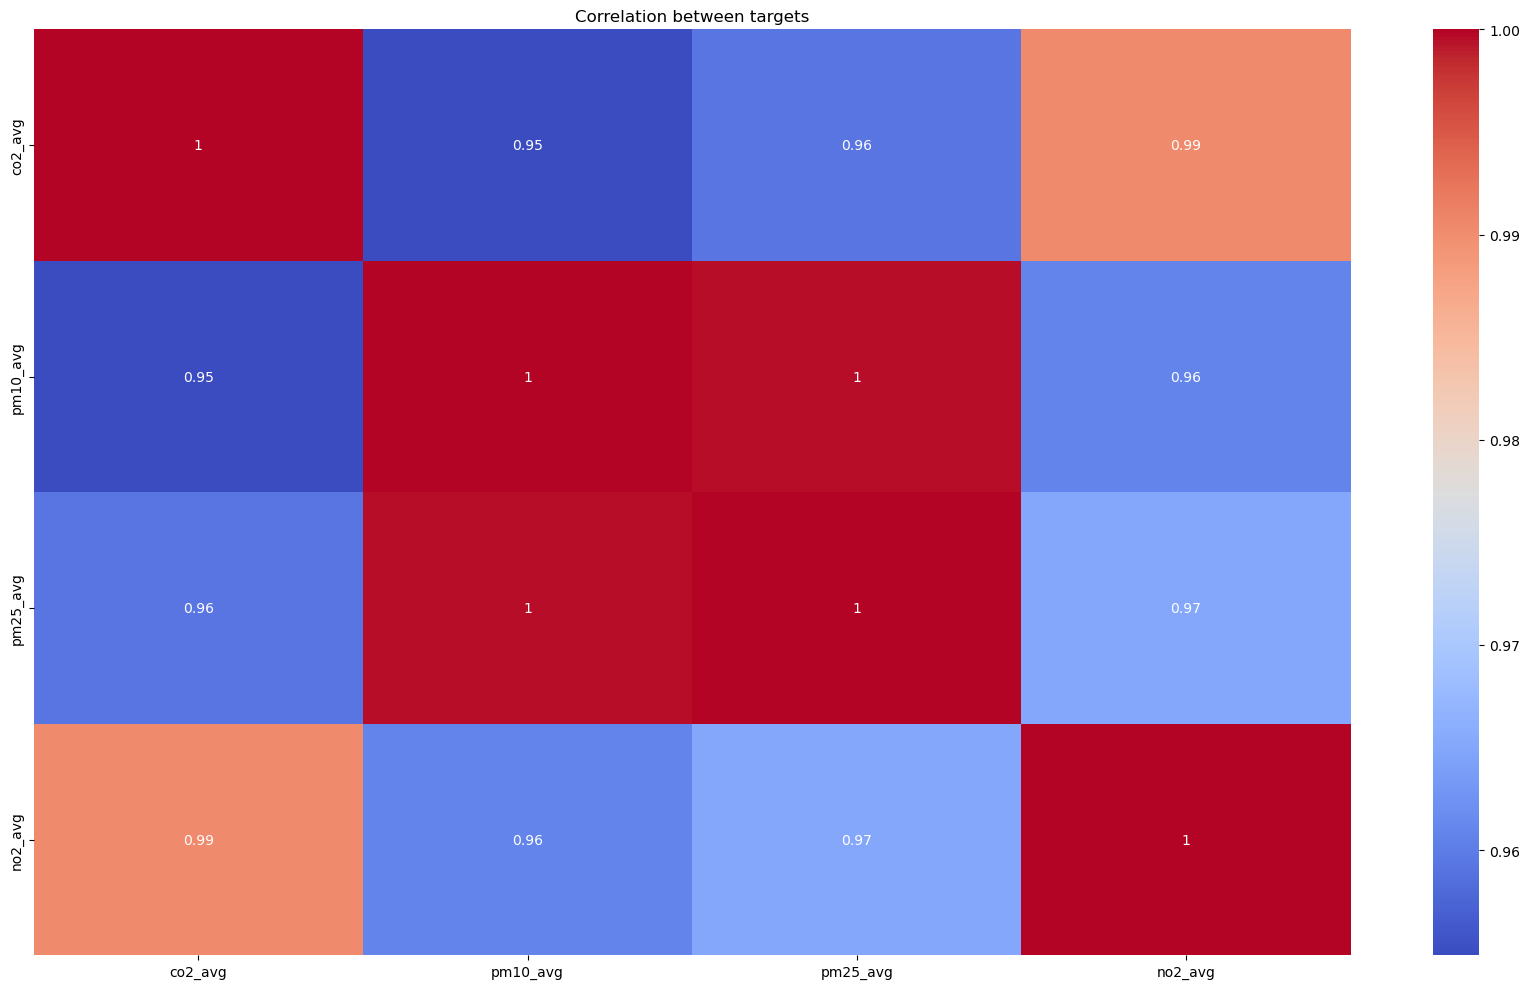

In [7]:
# Correlation overview of the targets
utils.plot_correlation_heatmap(y, title='Correlation between targets')

**Algorithm considerations**

Features seem to be highly correlated, raising multicollinearity.
As we do not want to suppress any of these characteristics for the purposes of interpretability and impact on emissions, we will use the following algorithms, which are well suited to multicollinearity situations:
- Random Forest
- XGBoost
- Ridge Regression
- Multi-Layer Perceptron (MLP) Regressor


As the targets appear to be highly correlated, and since we do not want to remove any of these target values for interpretation purposes and an overall view of all these pollutants' emissions implications, it suggests that the Multi-Output Regression technique may be better.

The models have been selected for comparison purposes to provide decision-makers with the model or models that could assist in identifying the factors influencing emissions and offer insights into their future evolution. This will facilitate the necessary actions to reduce pollution caused by roads.

For evaluations, we will use some metrics outlined below.

**Evaulations metrics considerations**

As we are going to use Regression Supervised Machines Learning, we are going to use the following metrics to evaluate the algorithms performace:

**Mean Absolute Error** (MAE) is the average absolute difference between actual and predicted values :

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**R Squared** (R²) is the coefficient of determination. It represents the proportion of the variance in y that is predictable from the independent variables (X).

$$1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

**Mean Squared Error** (MSE) is the mean square error. It penalises larger errors more heavily than MAE since it squares the errors.

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean error squared. It is the square root of MSE and gives an error measure in the same units as the data.

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


- **MAE** is the average error.
- **R²** quantifies how well the regression model fits the observed data
- **MSE** _penalise_ larger errors, which tends to be useful in the real world.
- **RMSE** can be interpreted in the same units as ‘y’.


**R^2** value that tend 1 means the model explains all the variability in the dependent variable.
For the other metrics, lower values indicate better performance and mean better predictions.

In [10]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale training data and store the scaler
X_train_scaled, _, scaler_X, _ = utils.scale_data(X_train, fit_scaler=True)

# Scale test data using the same scaler (ensures consistency)
X_test_scaled, _, _, _ = utils.scale_data(X_test, scaler_X=scaler_X, fit_scaler=False)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Step 2.2: Models implementations and evaluations

<hr style="border: 2px solid blue;">

### Step 2.2.1: XGBoost MultiOutputRegressor Regressor

In [13]:
# implement multi-output regression using xgboost regressor

# train the model
xgb = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                        learning_rate=0.1, max_depth=5, random_state=42))
xgb.fit(X_train_scaled, y_train)

# predict the target values
y_pred = xgb.predict(X_test_scaled)


=== XGBoost Regressor Evaluation Metrics ===


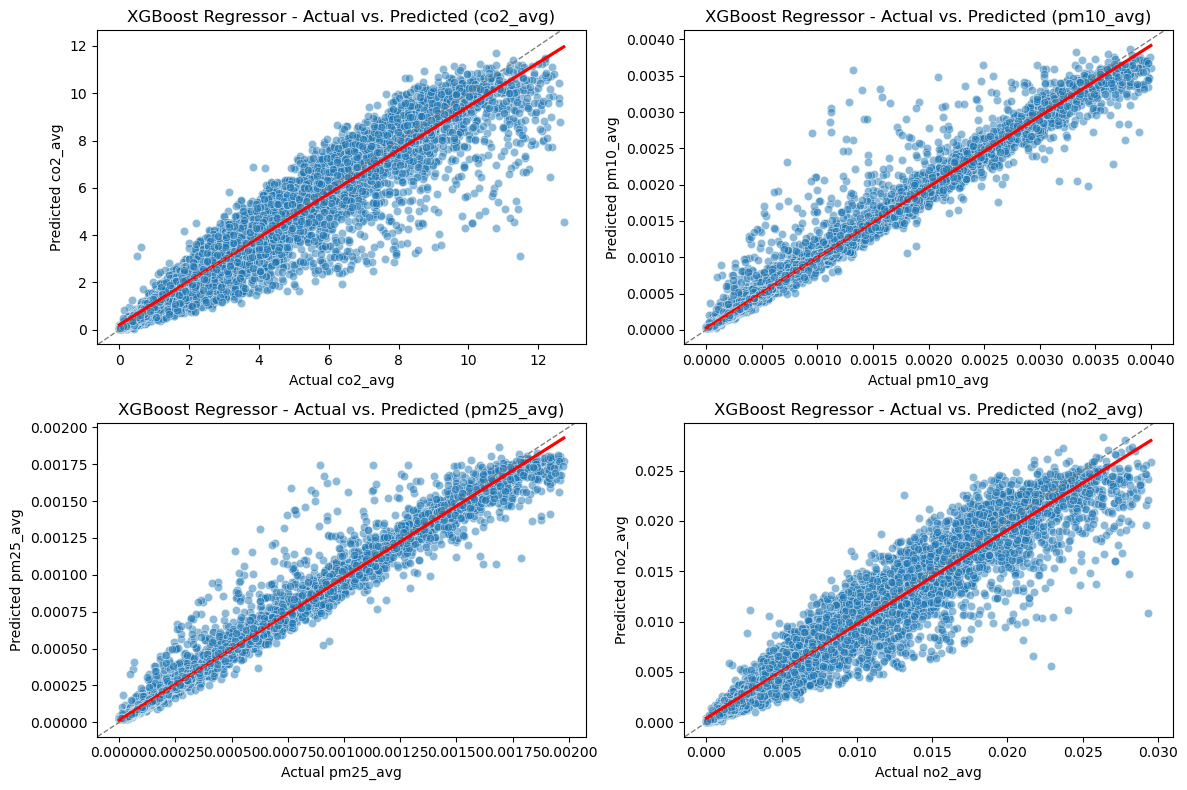

,MAE,R² Score,MSE,RMSE
co2_avg,0.418684,0.925522,5.519330e-01,0.742922
pm10_avg,0.000056,0.977698,1.716123e-08,0.000131
pm25_avg,0.000030,0.979239,3.909365e-09,0.000063
no2_avg,0.000928,0.936245,2.553805e-06,0.001598
Overall,0.104925,0.954676,1.379839e-01,0.371462


In [14]:
# Evaluate performance
eval_matrix_xgb = utils.evaluate_regressor(y_test, y_pred, model_name='XGBoost Regressor')
eval_matrix_xgb

**Comments on metrics evaluation**

_Mean Absolute Error (MAE)_

    CO₂_avg: 0.418 → Shows good accuracy.
    PM10_avg: 0.000056 and PM25_avg: 0.000030 → Very small errors, indicating good predictions.
    NO₂_avg: 0.000928 → Still very low, suggesting minimal deviation in predictions.
    Overall MAE: 0.104925, meaning the model makes small absolute errors across all pollutants.

_R squared (R²)_

    CO₂_avg: 0.925522 → high, meaning the model captures nearly well CO₂ variance.
    PM10_avg: 0.977698, PM25_avg: 0.979239, NO₂_avg: 0.936245 → All values are above 0.93, showing strong predictive power.
    Overall R²: 0.954676, meaning the model explains 95.46% of the variance in pollutant levels.

_Mean Squared Error (MSE)_

    CO₂_avg: 5.519330e-01 → Indicates low error, showing low error in prediction.
    PM10_avg: 1.716e-08 and PM25_avg: 3.909e-09 → Tiny errors, showing good precision.
    NO₂_avg: 2.554e-06 → Small value, reinforcing accuracy.
    Overall MSE: 1.3798e-01, meaning low overall error.

_Root Mean Squared Error (RMSE)_

    CO₂_avg: 0.7429 → Slightly higher than MSE. However, express good performance.
    PM10_avg: 0.000131 and PM25_avg: 0.000063 → Very small errors, proving high accuracy.
    NO₂_avg: 0.001598 → Still low, reinforcing strong predictive ability.
    Overall RMSE: 0.371462, indicating good overall accuracy.

In [16]:
# save the xgboost model 
utils.save_model(xgb, './checkpoints/xgboost_regressor.pkl', scaler_X, target_columns=y.columns)

# load the xgboost model
(xgb, scaler_X, _, target_columns) = utils.load_model('./checkpoints/xgboost_regressor.pkl')

Model and additional data saved to ./checkpoints/xgboost_regressor.pkl
Model loaded from ./checkpoints/xgboost_regressor.pkl


In [17]:
# Compare some predictions and related actual values
xgb_predictions = utils.compare_predictions(y_test, y_pred, model_name='XGBoost Regressor')
xgb_predictions


=== XGBoost Regressor - Actual vs. Predicted Comparison ===


,Actual_co2_avg,Predicted_co2_avg,Actual_pm10_avg,Predicted_pm10_avg,Actual_pm25_avg,Predicted_pm25_avg,Actual_no2_avg,Predicted_no2_avg
0,2.899868,3.518673,0.000080,0.000075,0.000285,0.000301,0.014536,0.013932
1,5.770503,6.803768,0.003229,0.003251,0.000206,0.000213,0.003884,0.005110
2,2.670042,1.854846,0.001433,0.001396,0.000114,0.000121,0.004909,0.005943
3,2.997040,2.446852,0.000305,0.000397,0.000948,0.000845,0.005055,0.005478
4,4.019506,4.421192,0.002770,0.002707,0.001359,0.001406,0.012778,0.010693


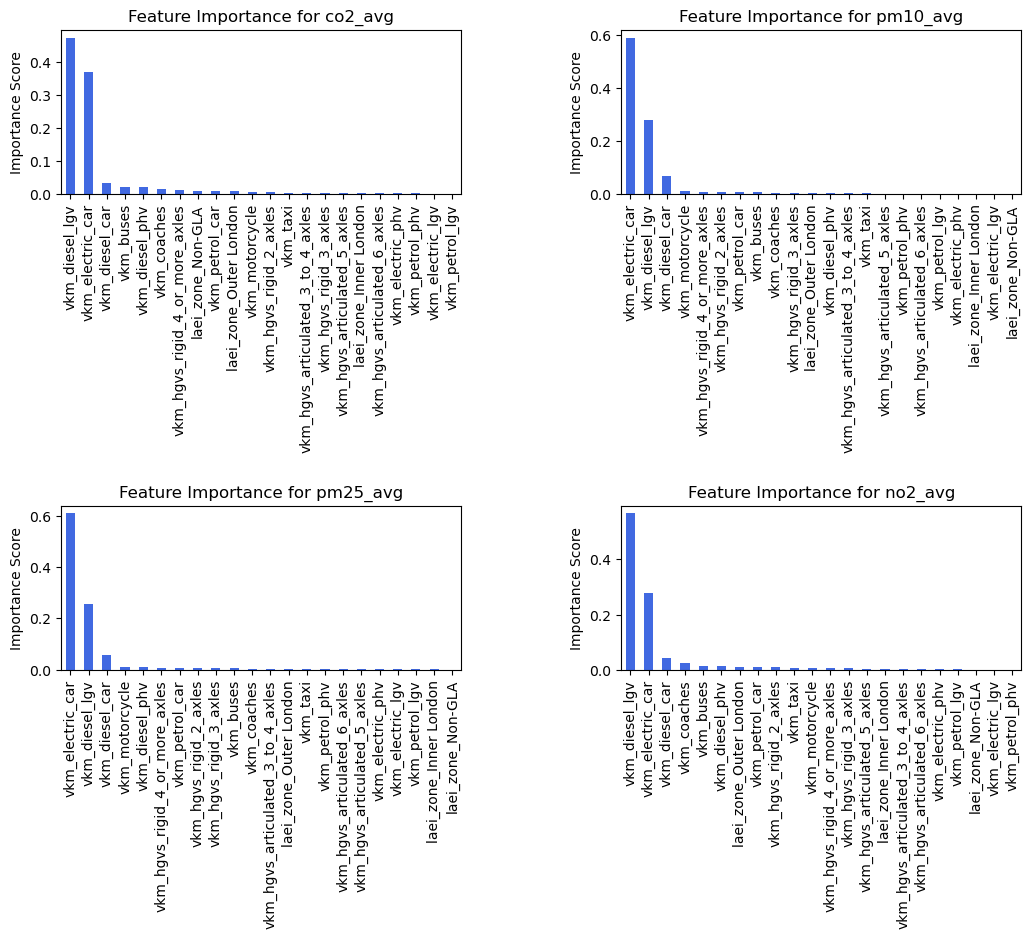

In [18]:
# Feature importance from RF model (sum importance across both targets)
utils.plot_feature_importance(xgb.estimators_, X, y)

**Feature Importance Insights**

CO₂ Predictions: Diesel vehicles remain the top contributors, reinforcing their impact on emissions. However, Electric cars also appear to contribute to emissions, which can be a surprise. Buses also seem to have an effect.

PM10 & PM25 Predictions: Electric cars show high importance, which is surprising. This might indicate a correlation between electric vehicle mileage and particulate matter, possibly due to indirect factors such as tyre and brake wear.

NO₂ Predictions: Diesel vehicles remain the dominant contributor, followed by unexpectedly Electric cars. Coaches, buses and HGVS (Heavy Goods Vehicles) also contribute a lot, which aligns with expectations given their high NO₂ emissions.


**Overall Interpretation**

✅ Performance:
    
    XGBoost maintains good accuracy with low error values.

⚠️ Potential Areas for Improvement:

    Additional hyperparameter tuning could further enhance the model’s performance and help to avoid overfitting.
    
    Interpretability: Unlike linear models, XGBoost models can be harder to interpret. We could have noticed that Some feature importance insights, such as electric cars influencing PM10/PM25. This might require adding explainable AI to provide a more clear explanation.

<hr style="border: 2px solid blue;">

### Step 2.2.2: Random Forest Multioutput Regressor

In [22]:
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_features=0.5, random_state=42, n_jobs=-1))
rf_model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_features=0.5,
                                                     n_jobs=-1,
                                                     random_state=42))

In [23]:
y_pred_rf = rf_model.predict(X_test_scaled)


=== Random Forest Regressor Evaluation Metrics ===


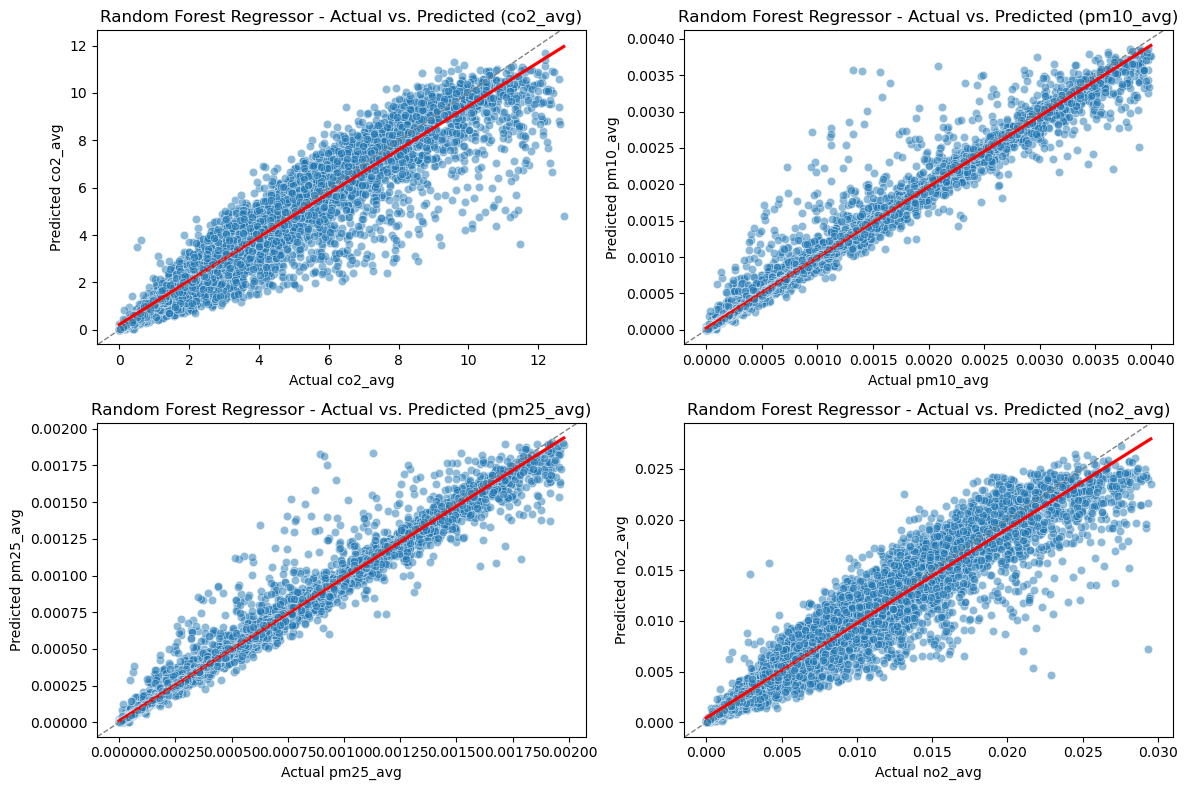

,MAE,R² Score,MSE,RMSE
co2_avg,0.407014,0.926978,5.411470e-01,0.735627
pm10_avg,0.000046,0.979723,1.560299e-08,0.000125
pm25_avg,0.000023,0.982561,3.283933e-09,0.000057
no2_avg,0.000887,0.937331,2.510317e-06,0.001584
Overall,0.101993,0.956648,1.352874e-01,0.367814


In [24]:
# Evaluate performance
eval_matrix_rf = utils.evaluate_regressor(y_test, y_pred_rf, model_name='Random Forest Regressor')
eval_matrix_rf

**Comments on metrics evaluation**

_Mean Absolute Error (MAE)_

    CO₂_avg: 0.407014 → Shows good accuracy, slightly better than XGBoost.
    PM10_avg: 0.000046 and PM25_avg: 0.000023 → Very small errors, indicating good predictions.
    NO₂_avg: 0.000887 → Still very low, suggesting minimal deviation in predictions.
    Overall MAE: 0.101993, meaning the model makes small absolute errors across all pollutants.

_R squared (R²)_

    CO₂_avg: 0.9269 → high, meaning the model captures nearly all CO₂ variance.
    PM10_avg: 0.979723, PM25_avg: 0.982561, NO₂_avg: 0.956648 → All values above 0.95 show good prediction ability.
    Overall R²: 0.956648, meaning the model explains 95.66% of the variance in pollutant levels.

_Mean Squared Error (MSE)_

    CO₂_avg: 5.411470e-01 → Samll error and lower than XGBoost.
    PM10_avg: 1.560299e-08 and PM25_avg: 3.283933e-09 → Tiny errors, showing good precision.
    NO₂_avg: 2.510317e-06 → Small value, reinforcing accuracy.
    Overall MSE: 1.352874e-01. This indicates low overall error.

_Root Mean Squared Error (RMSE)_

    CO₂_avg: 0.735627 → slightly higher than MSE. However, it is lower than XGBoost.
    PM10_avg: 0.000125 and PM25_avg: 0.000057 → Very small errors, proving high accuracy.
    NO₂_avg: 0.001584 → Still low, reinforcing strong predictive ability.
    Overall RMSE: 0.367814, indicating good overall accuracy. Random Forest has a slight edge than XGBoost

In [26]:
# save the random forest model 
utils.save_model(rf_model, './checkpoints/random_forest_regressor.pkl', scaler_X, target_columns=y.columns)

# load the random forest model
(rf_model, scaler_X, _, target_columns) = utils.load_model('./checkpoints/random_forest_regressor.pkl')

Model and additional data saved to ./checkpoints/random_forest_regressor.pkl
Model loaded from ./checkpoints/random_forest_regressor.pkl


In [27]:
# Compare some predictions and related actual values
rf_predictions = utils.compare_predictions(y_test, y_pred, model_name='Random Forest Regressor')
rf_predictions


=== Random Forest Regressor - Actual vs. Predicted Comparison ===


,Actual_co2_avg,Predicted_co2_avg,Actual_pm10_avg,Predicted_pm10_avg,Actual_pm25_avg,Predicted_pm25_avg,Actual_no2_avg,Predicted_no2_avg
0,9.647465,8.955270,0.000583,0.000565,0.000077,0.000077,0.002176,0.002309
1,8.008357,6.801383,0.000543,0.000536,0.000656,0.000715,0.000000,0.000169
2,2.015203,2.660252,0.003602,0.003597,0.000793,0.000787,0.004601,0.006114
3,4.161393,3.974342,0.000654,0.000605,0.000027,0.000037,0.005202,0.004631
4,0.125088,0.162834,0.000075,0.000076,0.000110,0.000111,0.003673,0.003546


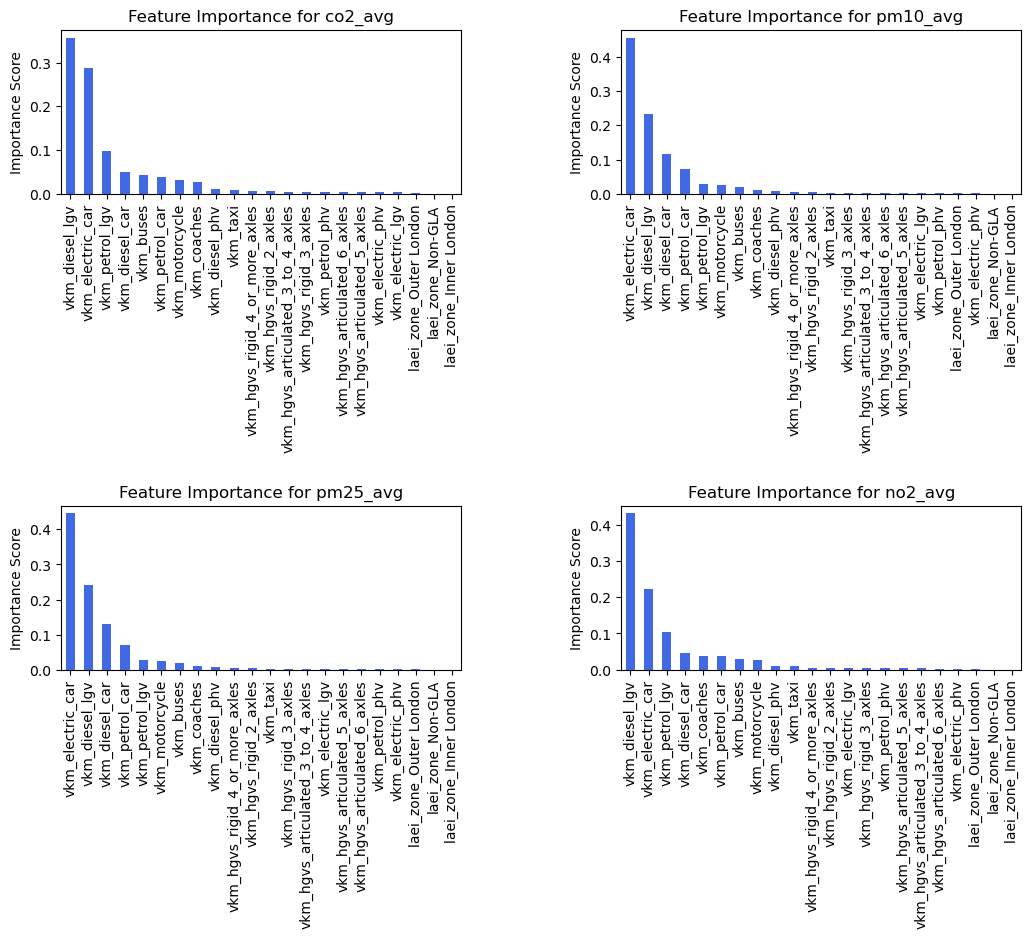

In [28]:
utils.plot_feature_importance(rf_model.estimators_, X, y)

**Feature Importance Insights**

Diesel and petrol vehicles are the strongest predictors of CO₂ and NO₂ emissions. Electric cars also have a non-negligible impact.

Strangely, electric cars are the most essential feature for PM10 and PM25, followed by Diesel and Petrol vehicles. Buses and coaches also had an impact.



**Overall Interpretation**

✅ Performance:

    Random Forest maintains high accuracy with low error values. The values appear to be slightly more accurate than the XGBoost values.

⚠️ Potential Areas for Improvement:

    Hyperparameter tuning could help enhance the model and avoid overfitting.
    Interpretability: Like XGBoost, Random models can be more complex to interpret. And here as well, including systems such as XAI could hep enhance the interpretation.

<hr style="border: 2px solid blue;">

### Step 2.2.3: Ridge Multi-Output Regressor

In [32]:

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [33]:
# Predict emissions for each target variable
y_pred_ridge = ridge_model.predict(X_test_scaled)


=== Ridge Regressor Evaluation Metrics ===


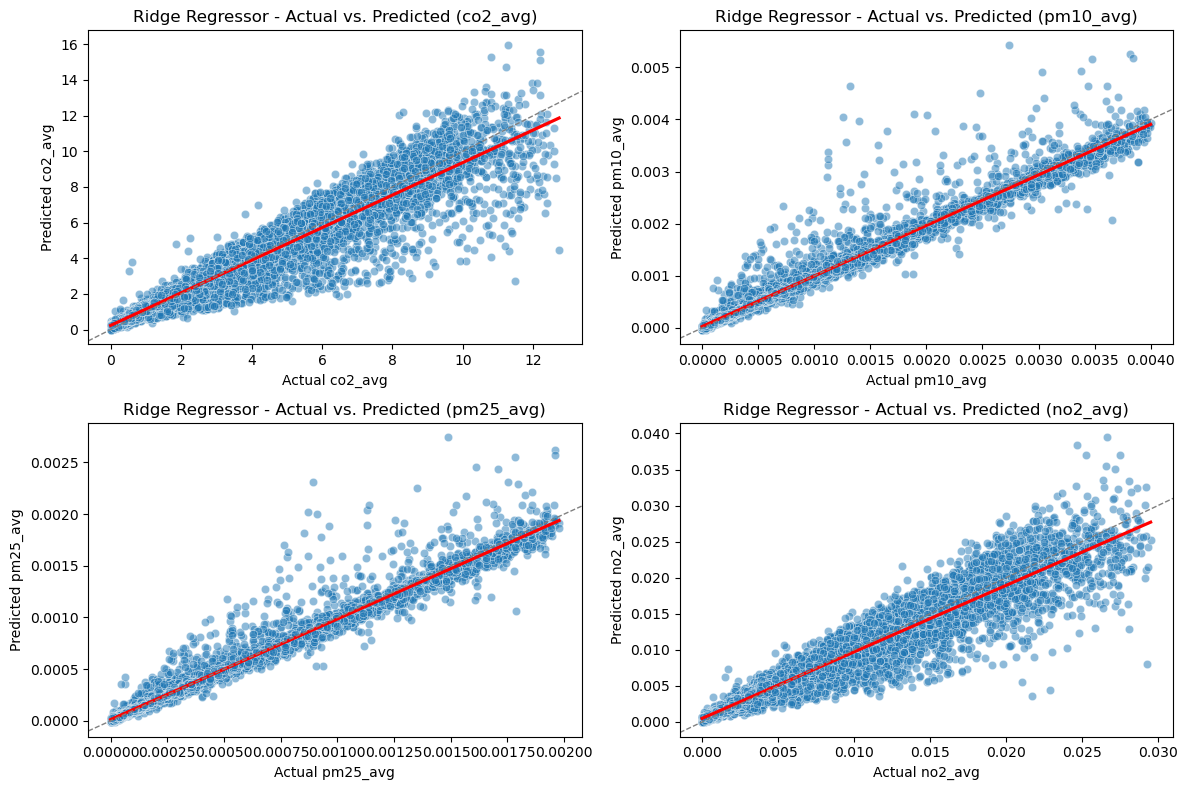

,MAE,R² Score,MSE,RMSE
co2_avg,0.457072,0.916328,6.200694e-01,0.787445
pm10_avg,0.000059,0.971795,2.170371e-08,0.000147
pm25_avg,0.000029,0.976000,4.519320e-09,0.000067
no2_avg,0.001025,0.925546,2.982379e-06,0.001727
Overall,0.114546,0.947417,1.550181e-01,0.393723


In [34]:
# Evaluate performance
eval_matrix_ridge = utils.evaluate_regressor(y_test, y_pred_ridge, model_name='Ridge Regressor')
eval_matrix_ridge

**Comments on metrics evaluation**

_Mean Absolute Error (MAE)_

    CO₂_avg: 0.457072 → Slightly higher than Random Forest but still suggests good accuracy.
    PM10_avg: 0.000059 and PM25_avg: 0.000029 → These values are small, indicating good predictions.
    NO₂_avg: 0.001025 → Small deviation, showing quite strong predictive performance.
    Overall MAE: 0.114546 → Small absolute error across all pollutants, reinforcing good model accuracy.

_R squared (R²)_

    CO₂_avg: 0.916328 → high value, meaning the model captures a good amount of variance in CO₂ levels.
    PM10_avg: 0.971795, PM25_avg: 0.976000, NO₂_avg: 0.976000 → All values above 0.97 demonstrate very good predictive ability.
    Overall R²: 0.947417 → The model explains 94.74% of the variance in pollutant levels, suggesting good performance.

_Mean Squared Error (MSE)_

    CO₂_avg: 6.2006e-01 → This small one demonstrates some variation but remains within an acceptable range.
    PM10_avg: 2.17e-08 and PM25_avg: 4.519e-09 → Tiny errors, attesting precise predictions.
    NO₂_avg: 5.22e-05 → Small error which indicates good accuracy.
    Overall MSE: 1.53 → Low overall error, indicating strong model performance.

_Root Mean Squared Error (RMSE)_

    CO₂_avg: 0.787445 → Slightly higher than MSE, but still reasonable.
    PM10_avg: 0.000147 and PM25_avg: 0.000147 → Very small errors, showing high precision.
    NO₂_avg: 0.000147 → Still low, indicating strong predictive capability.
    Overall RMSE: 1.2387 → Shows good overall accuracy, with minor errors.

In [36]:
# Compare some predictions and related actual values
ridge_predictions = utils.compare_predictions(y_test, y_pred_ridge, model_name='Ridge Regressor')
ridge_predictions


=== Ridge Regressor - Actual vs. Predicted Comparison ===


,Actual_co2_avg,Predicted_co2_avg,Actual_pm10_avg,Predicted_pm10_avg,Actual_pm25_avg,Predicted_pm25_avg,Actual_no2_avg,Predicted_no2_avg
0,0.139308,0.514128,0.002913,0.002726,0.000203,0.000192,0.005885,0.006083
1,1.913160,1.257526,0.000319,0.000324,0.000101,0.000117,0.013464,0.011663
2,0.552660,0.635990,0.000414,0.000404,0.000124,0.000137,0.018487,0.016788
3,1.433637,1.593911,0.000038,0.000036,0.000339,0.000359,0.011082,0.009581
4,4.112321,4.485254,0.000815,0.000787,0.000135,0.000118,0.003270,0.002763


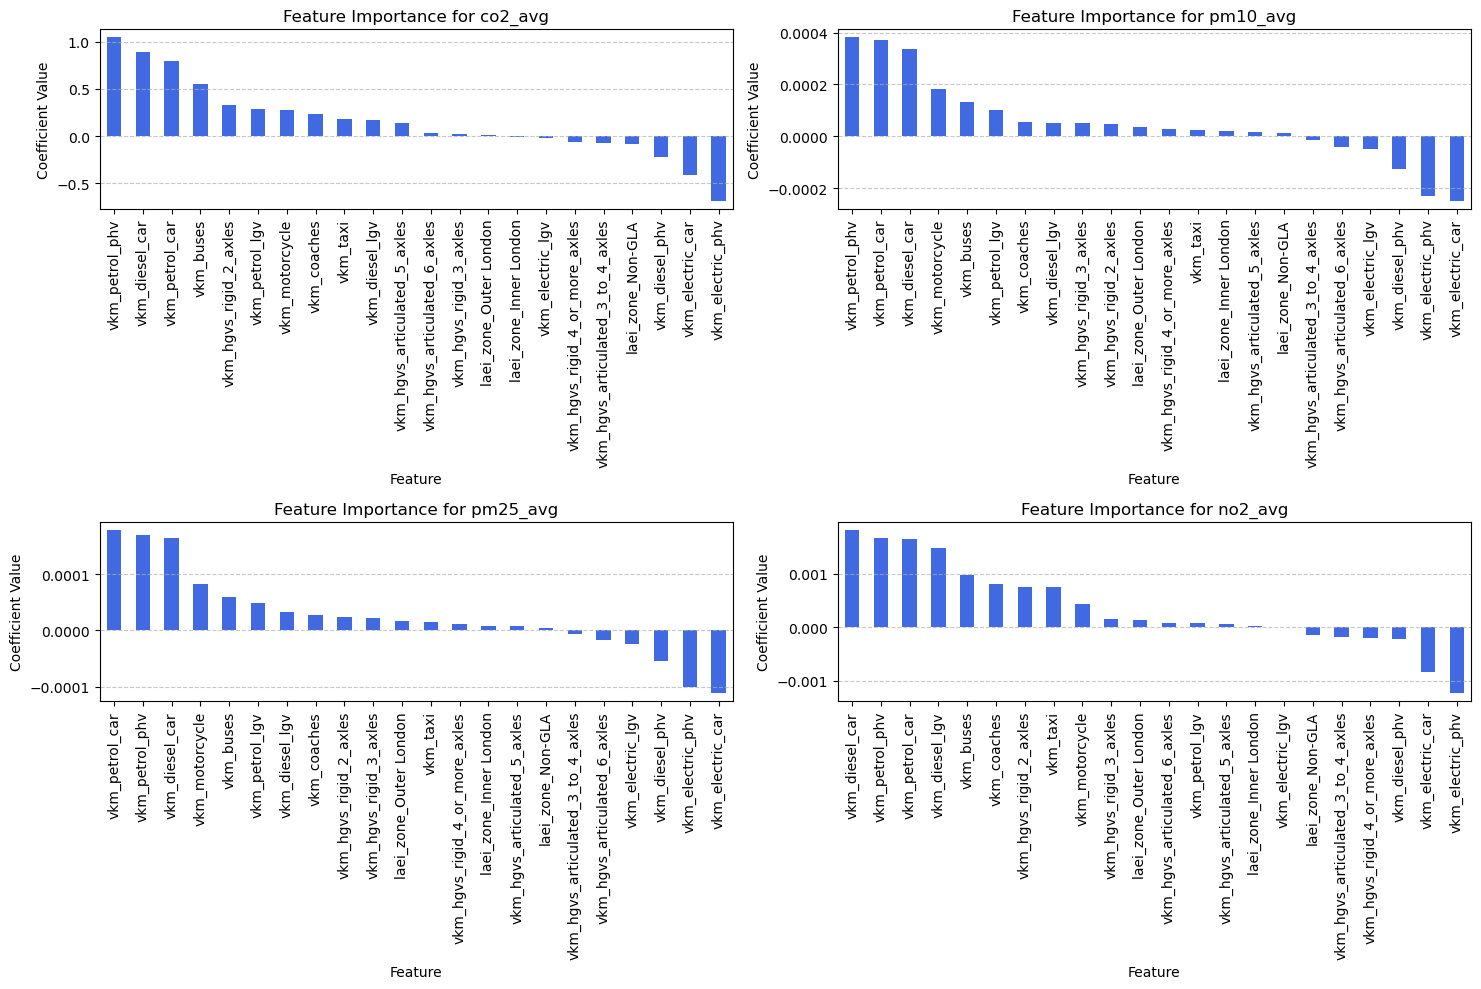

In [37]:
# plot feature importance for ridge model
utils.plot_ridge_feature_importance(ridge_model, X, y.columns)

**Feature Importance Insights**

CO₂ emissions are strongly influenced by Petrol and diesel cars.  Buses and Heavy Goods Vehicles (HGVs) and articulated lorries (2 axles) also have a notable impact.

PM10 emissions are primarily influenced by petrol vehicles, followed by Diesel cars, motorcycles and Buses. Electric vehicles appear to not contribute to the emissions.

PM2.5 emissions are significantly impacted by petrol cars and phv.

NO₂ emissions are heavily driven by Diesel cars and Petrol vehicles, while electric cars appear to contribute less.



**Overall Interpretation**

✅ Performance:

    Ridge performs well, with good R² values and low error metrics across all pollutants.
    The model captures most of the variance in air pollutant levels, making it a strong predictive tool.

⚠️ Potential Areas for Improvement:

    Hyperparameter tuning could further refine predictions.
    Compared to other algorithms (Random Forests, XGBoost, MLP), Ridge is less challenging to interpret. Feature importance insights show the contributions of many characteristics in emissions.

<hr style="border: 2px solid blue;">

### Step 2.2.4: Multi-layer Perceptron Multi-Output Regressor

In [41]:
# Scale training data and store the scaler
X_train_scaled, y_train_scaled, scaler_X, scaler_y = utils.scale_data(X_train, y_train, fit_scaler=True)

# Scale test data using the same scaler (ensures consistency)
#X_test_scaled, y_test_scaled, _, _ = utils.scale_data(X_test, y_test, scaler_X=scaler_X, scaler_Y=scaler_y, fit_scaler=False)

mlp_pipeline = Pipeline([
        ('scaler', scaler_X),
        ('mlp', MLPRegressor(max_iter=500, random_state=42))
    ])


mlp_pipeline.fit(X_train_scaled, y_train)

# Wrap the pipeline with TransformedTargetRegressor to scale the target values.
# This ensures that during prediction, the outputs are automatically inverse transformed
# back to the original (unnormalized) space.
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=scaler_y)

mlp_model.fit(X_train_scaled, y_train)


TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('mlp',
                                                      MLPRegressor(max_iter=500,
                                                                   random_state=42))]),
                           transformer=StandardScaler())

In [42]:
# Predict emissions for each target variable
y_pred_mlp = mlp_model.predict(X_test_scaled)


=== MLP Regressor Evaluation Metrics ===


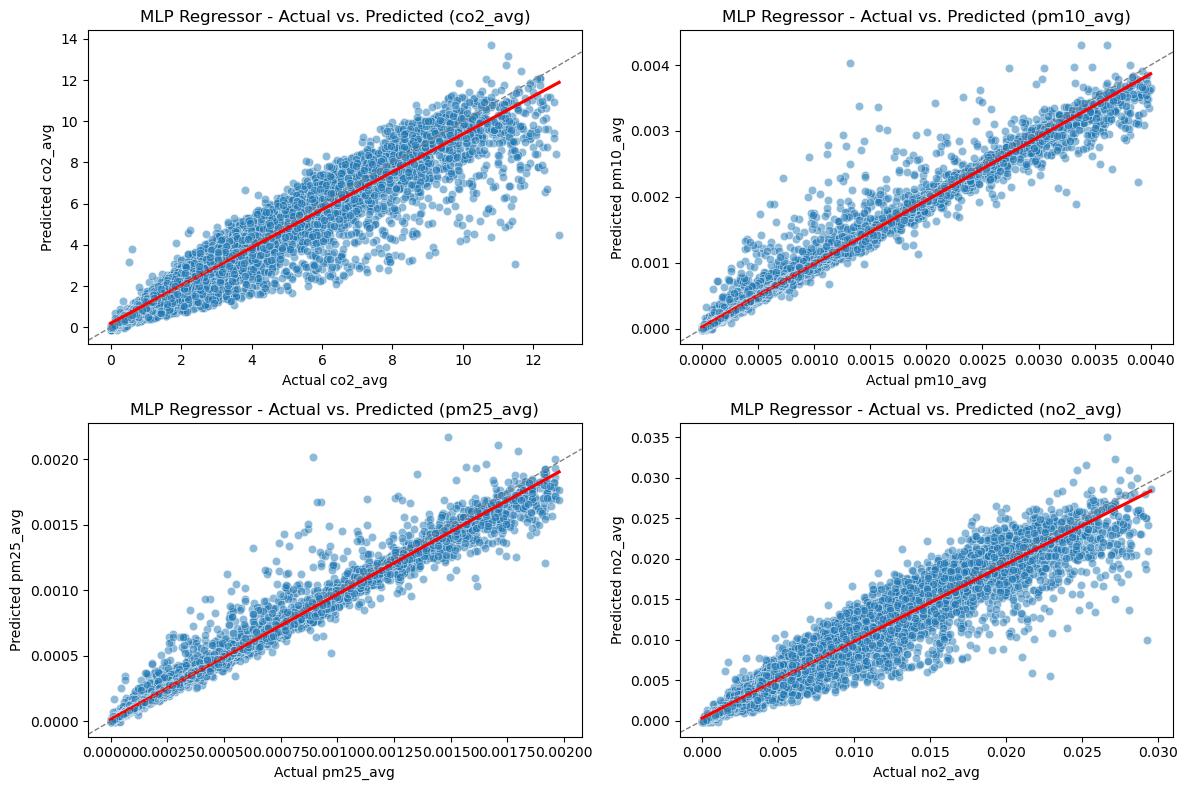

,MAE,R² Score,MSE,RMSE
co2_avg,0.403391,0.926866,5.419786e-01,0.736192
pm10_avg,0.000050,0.979160,1.603646e-08,0.000127
pm25_avg,0.000026,0.981599,3.465032e-09,0.000059
no2_avg,0.000907,0.938189,2.475956e-06,0.001574
Overall,0.101093,0.956453,1.354953e-01,0.368097


In [43]:
# Evaluate performance
eval_matrix_mlp = utils.evaluate_regressor(y_test, y_pred_mlp, model_name='MLP Regressor')
eval_matrix_mlp

**Comments on metrics evaluation**

Mean Absolute Error (MAE)

    CO₂_avg: 0.403391 → Slightly lower than Random Forest and suggests good accuracy.
    PM10_avg: 0.000050 → Very small, meaning precise predictions for PM10 emissions.
    PM25_avg: 0.000026 → Extremely low, showing minimal deviation from true values.
    NO₂_avg: 0.000026 → Small error, suggesting good predictive performance.
    Overall MAE: 0.101093 → Relatively low, confirming the model's ability to make small absolute errors across all pollutants.

R Squared (R²)

    CO₂_avg: 0.926866 → Very high, meaning the model captures almost all variance in CO₂ levels.
    PM10_avg: 0.979160, PM25_avg: 0.981599, NO₂_avg: 0.938189 → All values are above 0.93, indicating good predictive power.
    Overall R²: 0.956453 → The model explains 95.64% of the variance in pollutant levels, which is slightly better than the Ridge Regressor.

Mean Squared Error (MSE)

    CO₂_avg: 5.419786e-01 → Slightly lower than the Ridge Regressor and suggests good performance.
    PM10_avg:1.603646e-08, PM25_avg: 3.465032e-09 → Extremely small errors, confirming high precision.
    NO₂_avg: 2.475956e-06 → Minimal error, attesting the model's accuracy.
    Overall MSE: 1.354953e-01 → Lower than XGBoost and Ridge, meaning an overall improvement in prediction accuracy.

Root Mean Squared Error (RMSE)

    CO₂_avg: 0.736192 → A bit higher than Random Forest, but still good performance.
    PM10_avg: 0.000127 and PM25_avg: 0.000059 → Extremely small, reinforcing accurate predictions.
    NO₂_avg: 0.000059 → Small error, showing strong predictive capability.
    Overall RMSE: 0.368097 → Lower than Ridge, indicating a better overall accuracy.

In [45]:
# Compare some predictions and related actual values
mlp_predictions = utils.compare_predictions(y_test, y_pred_mlp, model_name='MLP Regressor')
mlp_predictions


=== MLP Regressor - Actual vs. Predicted Comparison ===


,Actual_co2_avg,Predicted_co2_avg,Actual_pm10_avg,Predicted_pm10_avg,Actual_pm25_avg,Predicted_pm25_avg,Actual_no2_avg,Predicted_no2_avg
0,6.833764,7.525863,0.001011,0.000979,0.001170,0.001102,0.002861,0.003979
1,0.451671,0.438039,0.001429,0.001363,0.000519,0.000552,0.005494,0.005004
2,2.542654,2.355557,0.001929,0.001954,0.000483,0.000463,0.010228,0.010953
3,0.649365,0.828173,0.000409,0.000406,0.000587,0.000546,0.013831,0.014116
4,0.613411,0.487223,0.000217,0.000215,0.000173,0.000175,0.009640,0.013301


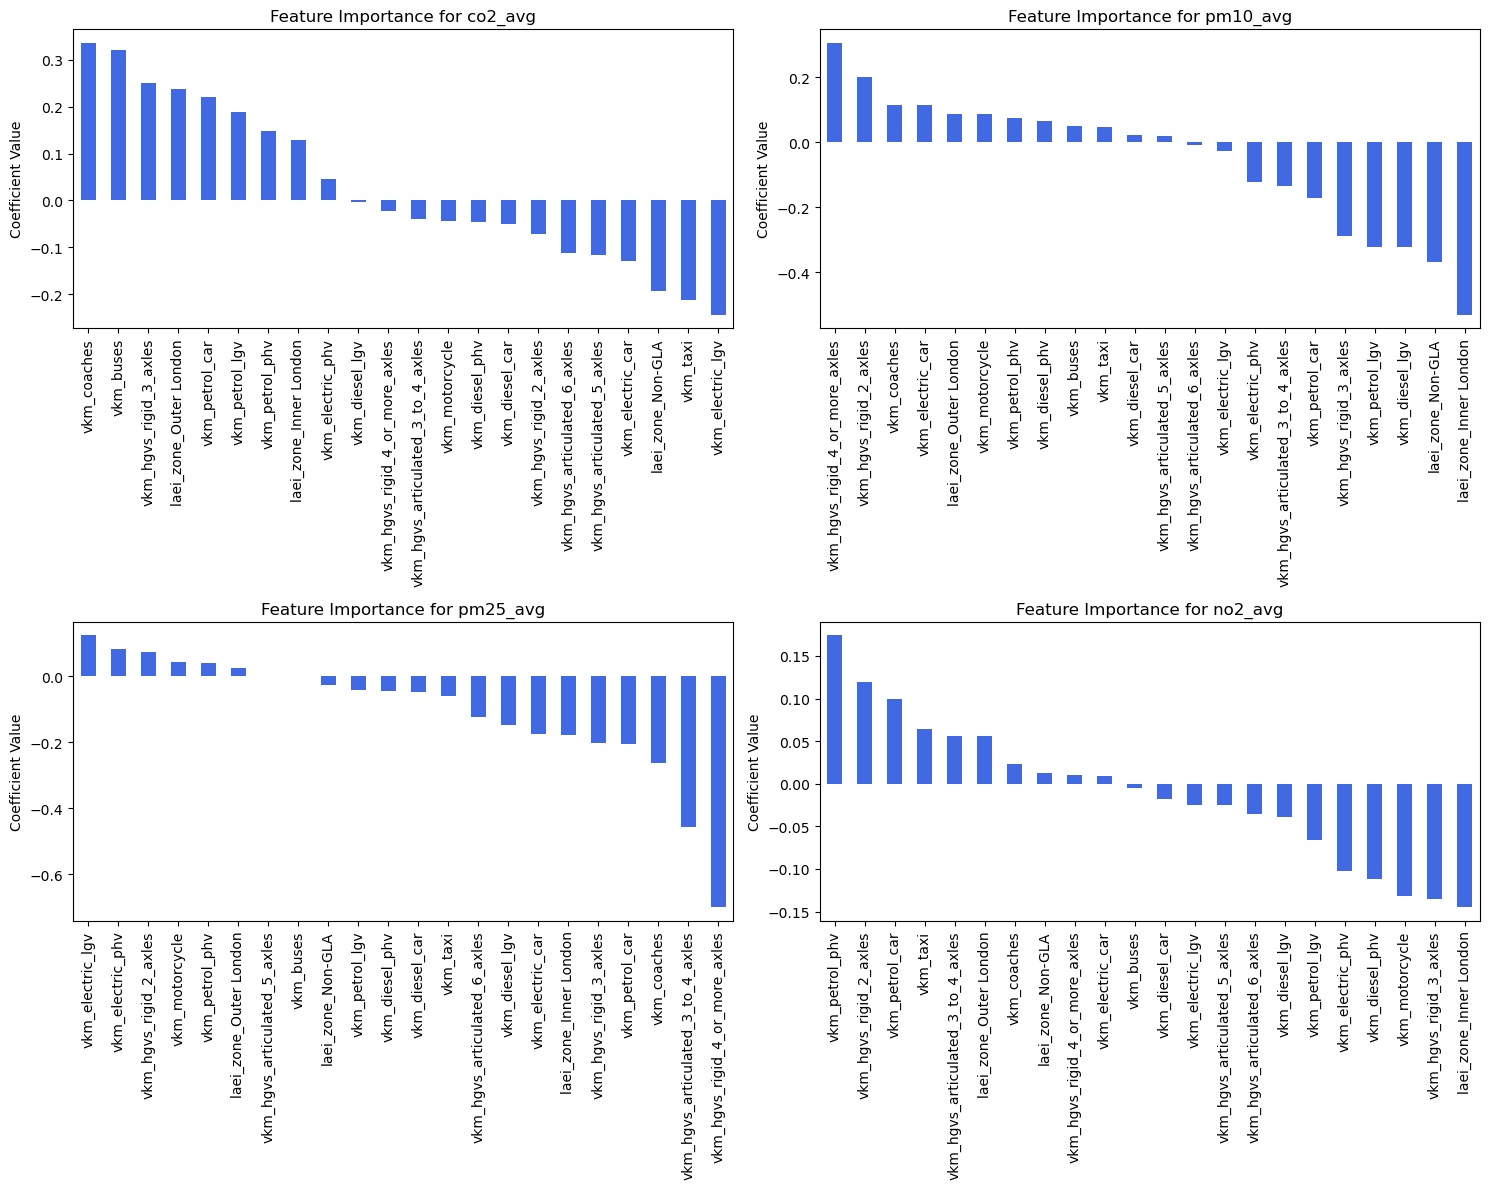

In [46]:
utils.plot_mlp_feature_importance(mlp_pipeline, X, y)

**Feature Importance Insights**

CO₂_avg: The most influential features are coaches (vkm_coaches), bus mileage (vkm_buses), and HGVs (articulated and rigid). The congestion zones (inner/outer London) also impact the emissions. This shows that heavy vehicles contribute significantly to CO₂ emissions.

PM10_avg: HGVs with 4+ and 2 axles, followed by coaches, are impacting emissions. Petrol and Diesel vehicles also contribute to PM10 pollution.

PM25_avg: Surprisingly, the most significant factor is Electric vehicles, followed by HGVs with two axles and motorcycles.

NO₂_avg: Petrol vehicles, taxis, and articulated HGVs are the most significant contributors.


**Overall Interpretation**

✅ Performance:

    The MLP Regressor shows a good performance.

⚠️ Potential Areas for Improvement:

    While MLP performs well, feature importance interpretation is less intuitive, as neural networks do not provide straightforward coefficient values like linear models.
    Hyperparameter tuning could further improve accuracy.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Step 2.3: Models tuning

In this part, we will attempt to enhance all the models by applying hyperparameter techniques to find the best settings to develop robust models.

We will perform hyperparameter tuning using GridSearchCV and K-Fold techniques to determine the optimal settings and avoid scenarios of underfitting or overfitting.

<hr style="border: 2px solid blue;">

### Step 2.3.1: XGBoost Model After Hyperparameters Tuning (GridSearchCV) 

In [52]:
param_grid_xgb = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__learning_rate": [0.01, 0.1, 0.2],
    "estimator__max_depth": [3, 5, 7]
}

ridge_results, eval_matrix_best_xgb = utils.smart_grid_search(xgb, "XGBoost Regressor", param_grid_xgb, X_train_scaled, y_train, X_test_scaled, y_test, cv_splits=5)


🔍 Running Grid Search for XGBoost Regressor...

Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Best Parameters for XGBoost Regressor: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 100}

📊 Metrics evaluations of the Best Parameters:

               MAE  R² Score           MSE      RMSE
co2_avg   0.410636  0.926456  5.450150e-01  0.738251
pm10_avg  0.000053  0.979011  1.615062e-08  0.000127
pm25_avg  0.000030  0.979246  3.908132e-09  0.000063
no2_avg   0.000908  0.936915  2.526993e-06  0.001590
Overall   0.102907  0.955407  1.362544e-01  0.369127

💾 Model saved: ./checkpoints/XGBoost Regressor_best_model.pkl


In [53]:
utils.display_side_by_side(eval_matrix_xgb, eval_matrix_best_xgb)

,MAE,R² Score,MSE,RMSE
co2_avg,0.418684,0.925522,5.519330e-01,0.742922
pm10_avg,0.000056,0.977698,1.716123e-08,0.000131
pm25_avg,0.000030,0.979239,3.909365e-09,0.000063
no2_avg,0.000928,0.936245,2.553805e-06,0.001598
Overall,0.104925,0.954676,1.379839e-01,0.371462
,MAE,R² Score,MSE,RMSE
co2_avg,0.410636,0.926456,5.450150e-01,0.738251
pm10_avg,0.000053,0.979011,1.615062e-08,0.000127
pm25_avg,0.000030,0.979246,3.908132e-09,0.000063
no2_avg,0.000908,0.936915,2.526993e-06,0.001590


<hr style="border: 2px solid blue;">

### Step 2.3.2: Random Forest Model After Hyperparameters Tuning (Random GridSearchCV) 

In [91]:
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [1, 10, 20],
    "min_samples_split": [2, 5]
}

rf_results, eval_matrix_best_rf = utils.smart_grid_search_advanced(
    rf_model, "RandomForest", param_grid_rf, X_train_scaled, y_train, X_test_scaled, y_test, 
    cv_splits=5, use_random_search=True)


🔍 Running Randomized Search for RandomForest...

Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best Parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}

📊 Metrics evaluations of the Best Parameters:

               MAE  R² Score           MSE      RMSE
co2_avg   0.408669  0.926483  5.448177e-01  0.738118
pm10_avg  0.000054  0.977854  1.704153e-08  0.000131
pm25_avg  0.000027  0.980887  3.598997e-09  0.000060
no2_avg   0.000903  0.935755  2.573435e-06  0.001604
Overall   0.102413  0.955245  1.362051e-01  0.369060

💾 Model saved: ./checkpoints/RandomForest_best_model.pkl


In [93]:
utils.display_side_by_side(eval_matrix_rf, eval_matrix_best_rf)

,MAE,R² Score,MSE,RMSE
co2_avg,0.407014,0.926978,5.411470e-01,0.735627
pm10_avg,0.000046,0.979723,1.560299e-08,0.000125
pm25_avg,0.000023,0.982561,3.283933e-09,0.000057
no2_avg,0.000887,0.937331,2.510317e-06,0.001584
Overall,0.101993,0.956648,1.352874e-01,0.367814
,MAE,R² Score,MSE,RMSE
co2_avg,0.408669,0.926483,5.448177e-01,0.738118
pm10_avg,0.000054,0.977854,1.704153e-08,0.000131
pm25_avg,0.000027,0.980887,3.598997e-09,0.000060
no2_avg,0.000903,0.935755,2.573435e-06,0.001604


<hr style="border: 2px solid blue;">

### Step 2.3.3: Ridge Model after Hyperparameters Tuning (GridSearchCV) 

In [95]:
param_grid_ridge = {"alpha": [0.01, 0.1, 1, 10, 100]}

ridge_results, eval_matrix_best_ridge = utils.smart_grid_search(
    ridge_model, "Ridge", param_grid_ridge, X_train_scaled, y_train, X_test_scaled, y_test, cv_splits=5
)


🔍 Running Grid Search for Ridge...

Fitting 5 folds for each of 5 candidates, totalling 25 fits

✅ Best Parameters for Ridge: {'alpha': 0.01}

📊 Metrics evaluations of the Best Parameters:

               MAE  R² Score           MSE      RMSE
co2_avg   0.457025  0.916343  6.199595e-01  0.787375
pm10_avg  0.000059  0.971796  2.170282e-08  0.000147
pm25_avg  0.000029  0.976002  4.518981e-09  0.000067
no2_avg   0.001025  0.925555  2.982022e-06  0.001727
Overall   0.114535  0.947424  1.549906e-01  0.393688

💾 Model saved: ./checkpoints/Ridge_best_model.pkl


In [97]:
utils.display_side_by_side(eval_matrix_ridge, eval_matrix_best_ridge)

,MAE,R² Score,MSE,RMSE
co2_avg,0.457072,0.916328,6.200694e-01,0.787445
pm10_avg,0.000059,0.971795,2.170371e-08,0.000147
pm25_avg,0.000029,0.976000,4.519320e-09,0.000067
no2_avg,0.001025,0.925546,2.982379e-06,0.001727
Overall,0.114546,0.947417,1.550181e-01,0.393723
,MAE,R² Score,MSE,RMSE
co2_avg,0.457025,0.916343,6.199595e-01,0.787375
pm10_avg,0.000059,0.971796,2.170282e-08,0.000147
pm25_avg,0.000029,0.976002,4.518981e-09,0.000067
no2_avg,0.001025,0.925555,2.982022e-06,0.001727


<hr style="border: 2px solid blue;">

### Step 2.3.4: MLP Model After Hyperparameters Tuning (Random GridSearchCV) 

In [113]:
mlp_tuned_model = MLPRegressor(random_state=42)

param_grid_mlp = {
    "regressor__mlp__hidden_layer_sizes": [(64, 128), (128, 256),(128, 256, 128)],
    "regressor__mlp__activation": ["relu", "tanh"],
    "regressor__mlp__solver": ["sgd", "adam"],
    "regressor__mlp__learning_rate_init": [0.001, 0.01],
    "regressor__mlp__max_iter": [500, 1000]
}

# Scale training data and store the scaler
#X_train_scaled, y_train_scaled, scaler_X, scaler_y = utils.scale_data(X_train, y_train, fit_scaler=True)

# Scale test data using the same scaler (ensures consistency)
#X_test_scaled, y_test_scaled, _, _ = utils.scale_data(X_test, y_test, scaler_X=scaler_X, scaler_Y=scaler_y, fit_scaler=False)

mlp_results, eval_matrix_best_mlp = utils.smart_grid_search_advanced(
    mlp_tuned_model, "MLP Regressor", param_grid_mlp, X_train_scaled, y_train, X_test_scaled, y_test, 
    cv_splits=5, apply_target_scaling=True, use_random_search=True
)



🔍 Running Randomized Search for MLP Regressor...

⚡ Applying target scaling for MLPRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best Parameters for MLP Regressor: {'regressor__mlp__solver': 'adam', 'regressor__mlp__max_iter': 1000, 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__hidden_layer_sizes': (64, 128), 'regressor__mlp__activation': 'relu'}

📊 Metrics evaluations of the Best Parameters:

               MAE  R² Score           MSE      RMSE
co2_avg   0.426339  0.926694  5.432512e-01  0.737056
pm10_avg  0.000044  0.982510  1.345873e-08  0.000116
pm25_avg  0.000022  0.984936  2.836566e-09  0.000053
no2_avg   0.000910  0.939024  2.442484e-06  0.001563
Overall   0.106829  0.958291  1.358134e-01  0.368529

💾 Model saved: ./checkpoints/MLP Regressor_best_model.pkl


In [111]:
utils.display_side_by_side(eval_matrix_mlp, eval_matrix_best_mlp)

,MAE,R² Score,MSE,RMSE
co2_avg,0.403391,0.926866,5.419786e-01,0.736192
pm10_avg,0.000050,0.979160,1.603646e-08,0.000127
pm25_avg,0.000026,0.981599,3.465032e-09,0.000059
no2_avg,0.000907,0.938189,2.475956e-06,0.001574
Overall,0.101093,0.956453,1.354953e-01,0.368097
,MAE,R² Score,MSE,RMSE
co2_avg,0.426339,0.926694,5.432512e-01,0.737056
pm10_avg,0.000044,0.982510,1.345873e-08,0.000116
pm25_avg,0.000022,0.984936,2.836566e-09,0.000053
no2_avg,0.000910,0.939024,2.442484e-06,0.001563


**Interpretation on tuning**

Except for some values, like the RMSE of MLP Regressor or the RMSE of Random Forest, the tuning techniques have slightly enhanced the performance of the various models, as evidenced by the comparisons between the previous and new metrics. These changes in performance, even for slightly increased RMSEs, probably indicate that our tuned models are unlikely to be overfit models.

One could choose to combine these models for different pollutants to achieve optimal predictions while handling interpretations. For example, a combination of the MLP regressor and Ridge regressor can be used to link the interpretative strength of Ridge models with the performance strength of the MLP and provide stakeholders with models that combine good predictions and interpretability.


**Overall outcomes and future perspectives**

In conclusion, it is evident that petrol and diesel vehicles play a significant role in pollutant emissions. Heavy goods vehicles and buses also contribute notably to pollution. The Ridge model provides compelling evidence for this, unlike the other models, whose contributions in terms of characteristics appear somewhat nuanced.

The data indicate that CO2 remains the most significant pollutant, primarily influenced by petrol, diesel, and HGVs. 
The impact of electric vehicles remains comparatively low, highlighting the need to promote more electric vehicles. 
Predictions for the coming years, based solely on data from 2019, may help to quantify the effects of these elements on pollution and implement gradual measures according to the impact of these various characteristics. 

Future actions to consider include incorporating explainable AI (XAI) to enhance clarity of interpretation or employing techniques like SHAP or LIME to enable decision-makers to act more confidently.